In [111]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

### Check what stuff has run

In [113]:
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384

suitepath = join(wdir, nbody, sim, f'L{L}-N{N}')
simpaths = os.listdir(suitepath)

In [114]:
from collections import defaultdict

c = defaultdict(list)
for lhid in tqdm(range(2000)):
    lhid = str(lhid)
    simdir = join(suitepath, lhid)
    if not os.path.isdir(simdir):
        c['missing_dir'].append(lhid)
        continue
    files = os.listdir(simdir)
    if any(f.startswith('fastpm_') for f in files):
        c['fastpm_*'].append(lhid)
    if any(f.startswith('nbody_') for f in files):
        c['nbody_*'].append(lhid)
    if 'nbody.h5' in files:
        c['nbody.h5'].append(lhid)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 2277.43it/s]


In [115]:
for k, v in c.items():
    print(f'{k}: {len(v)}')

nbody.h5: 1926
missing_dir: 67


In [119]:
# print(','.join(sorted(c['missing_dir'], key=int)))
x = [str(int(i)-1000) for i in c['missing_dir']]
print(','.join(sorted(x)))

-318,-570,-571,-572,-573,-574,-575,-576,-577,-578,-579,-580,-581,-582,-583,-584,-585,-586,-587,-588,-589,-590,-591,-592,-593,-594,-595,-596,-597,-598,-599,430,457,481,548,605,662,682,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,759,760,942,969


In [67]:
# sorted(c['nbody_*'], key=int)
print('\n'.join(sorted(c['fastpm_*'], key=int)))

In [68]:
intersection = set(c['nbody.h5']).intersection(c['fastpm_*'])
print(intersection)

set()


### Sanity check those which have finished

In [84]:
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384

suitepath = join(wdir, nbody, sim, f'L{L}-N{N}')
simpaths = os.listdir(suitepath)

In [85]:
from collections import defaultdict

c = defaultdict(list)
for lhid in tqdm(range(2000, 3000)):
    lhid = str(lhid)
    simdir = join(suitepath, lhid)
    if not os.path.isdir(simdir):
        c['missing_dir'].append(lhid)
        continue
    files = os.listdir(simdir)
    if 'nbody.h5' in files:
        c['done'].append(lhid)

100%|██████████| 1000/1000 [00:00<00:00, 2479.56it/s]


In [87]:
from cmass.infer.loaders import get_cosmo
clhid = [int(x) for x in c['done']]
ccosmo = [
    get_cosmo(join(suitepath, str(lhid)))
    for lhid in clhid
]
ccosmo = np.array(ccosmo)

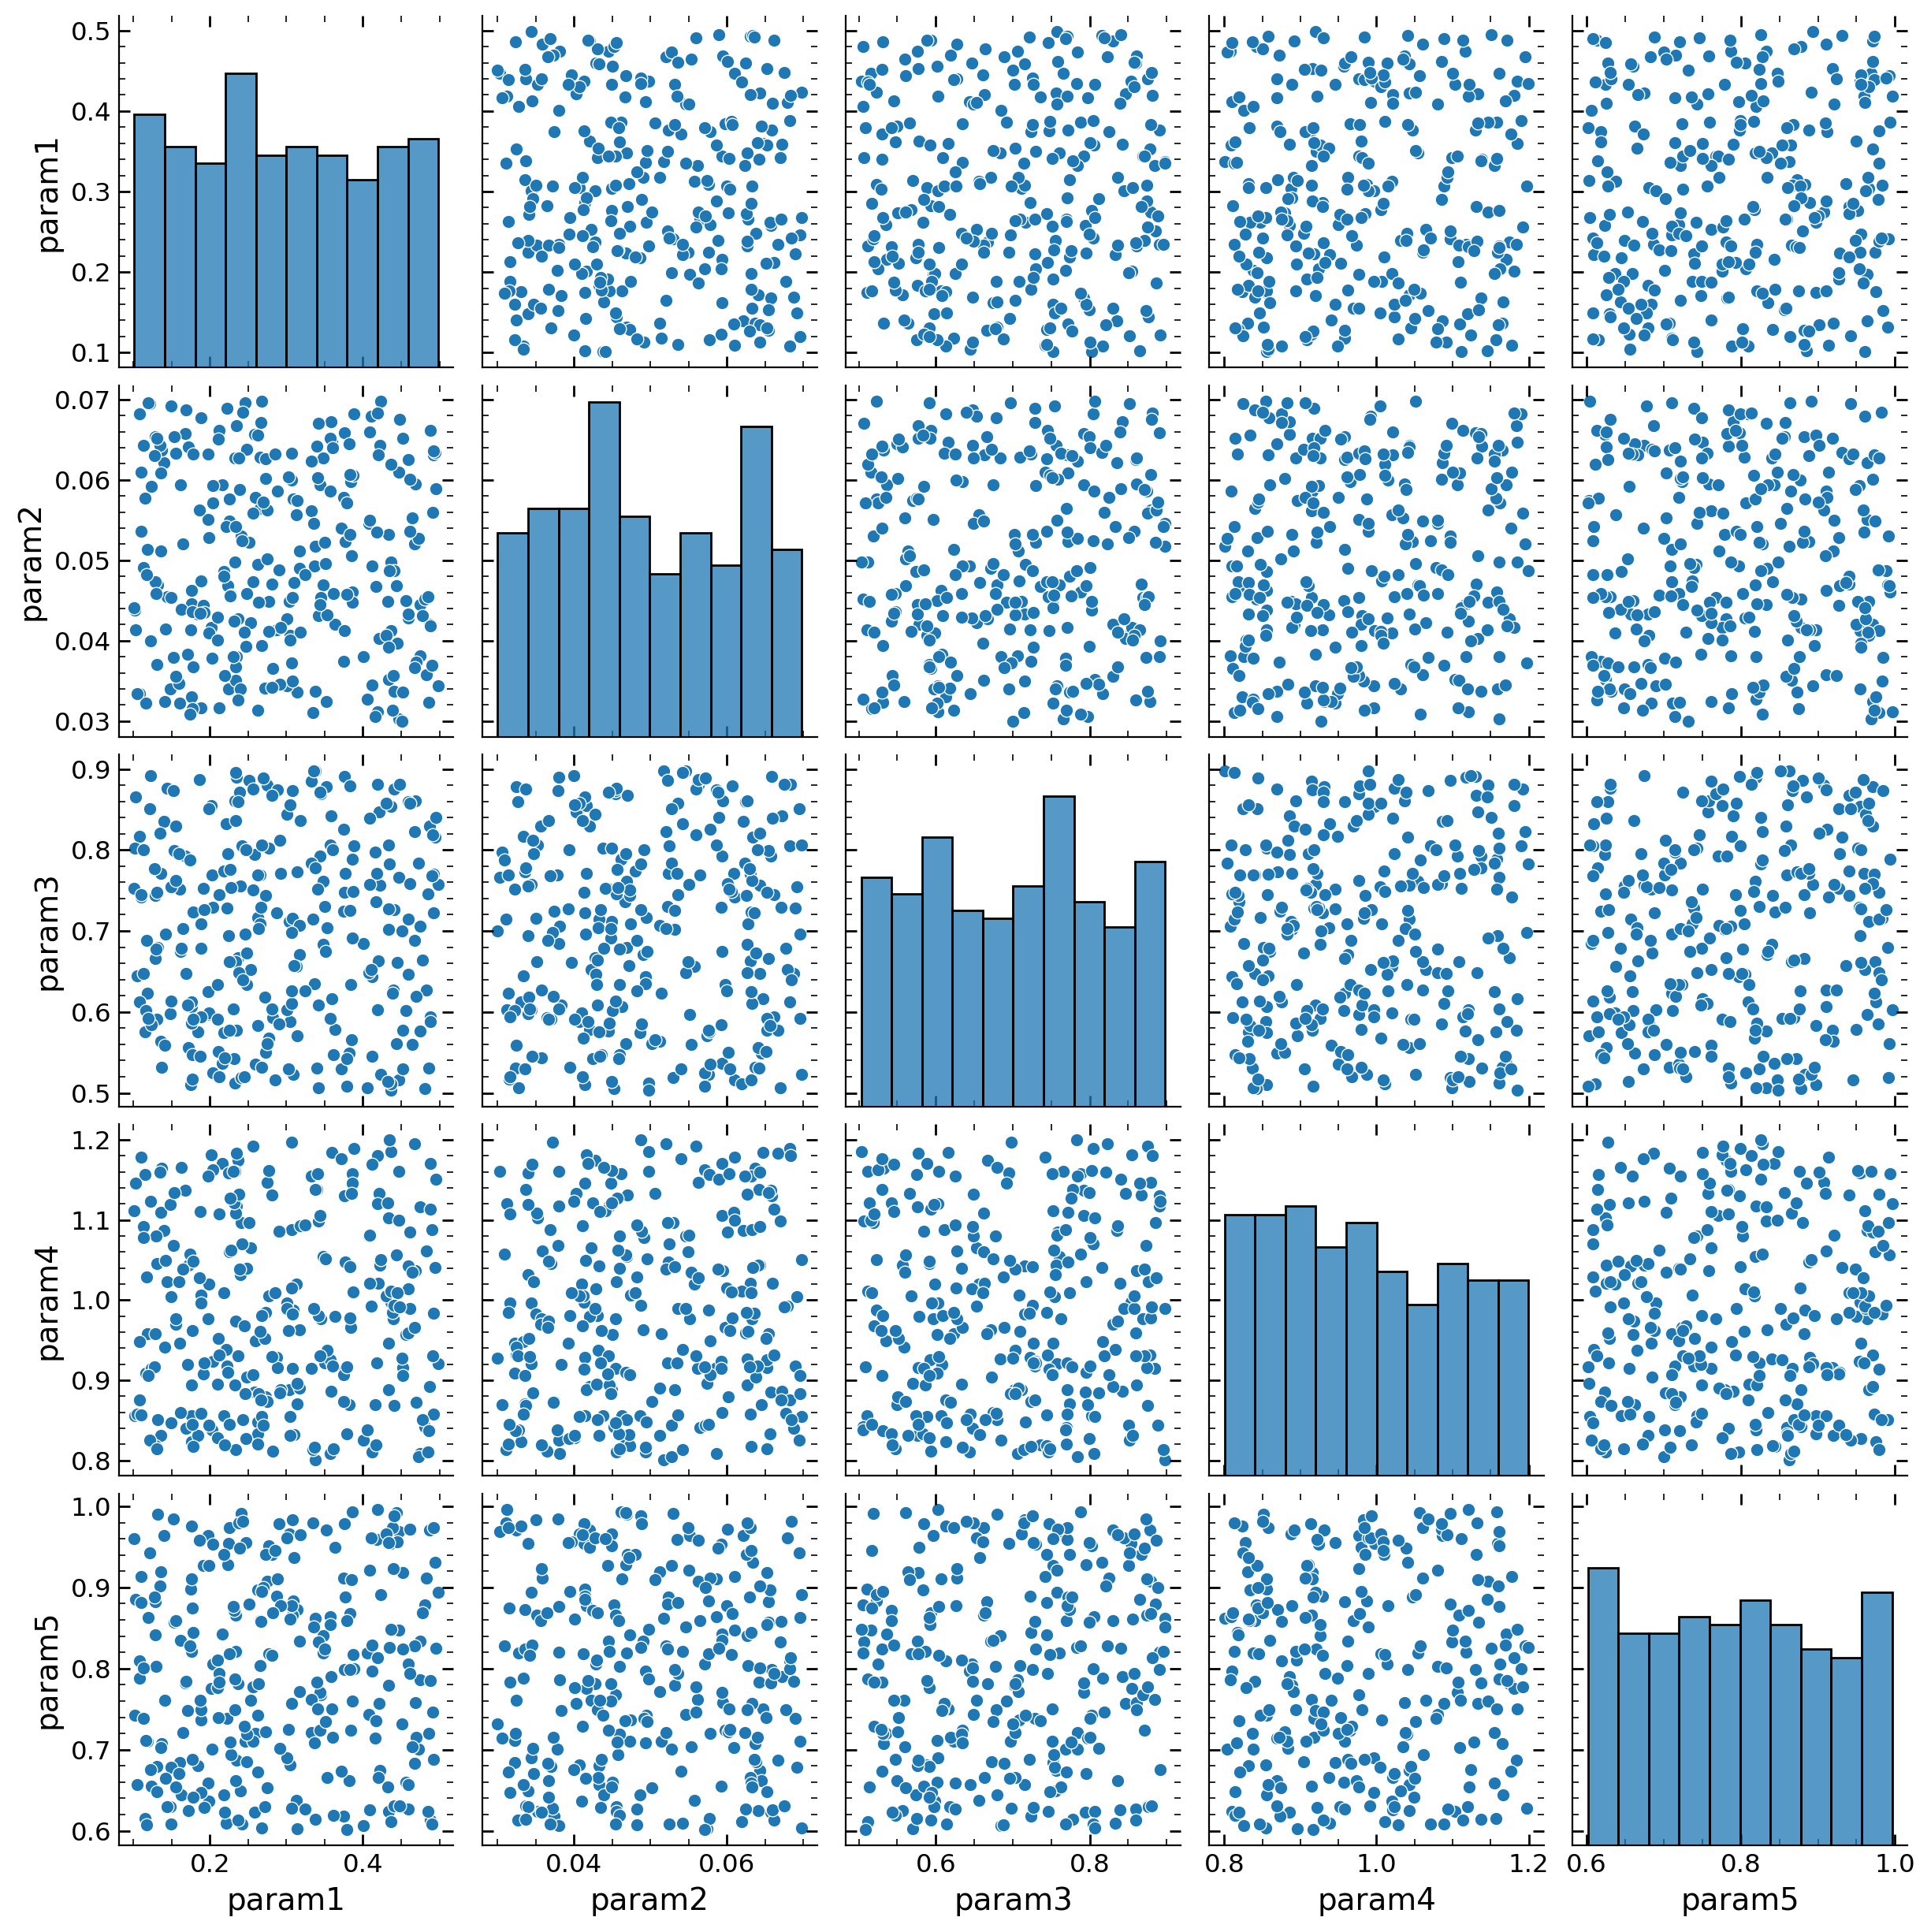

In [90]:
import seaborn as sns
import pandas as pd

ccosmo_df = pd.DataFrame(
    ccosmo, columns=['param1', 'param2', 'param3', 'param4', 'param5'])
sns.pairplot(ccosmo_df)
plt.show()

100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


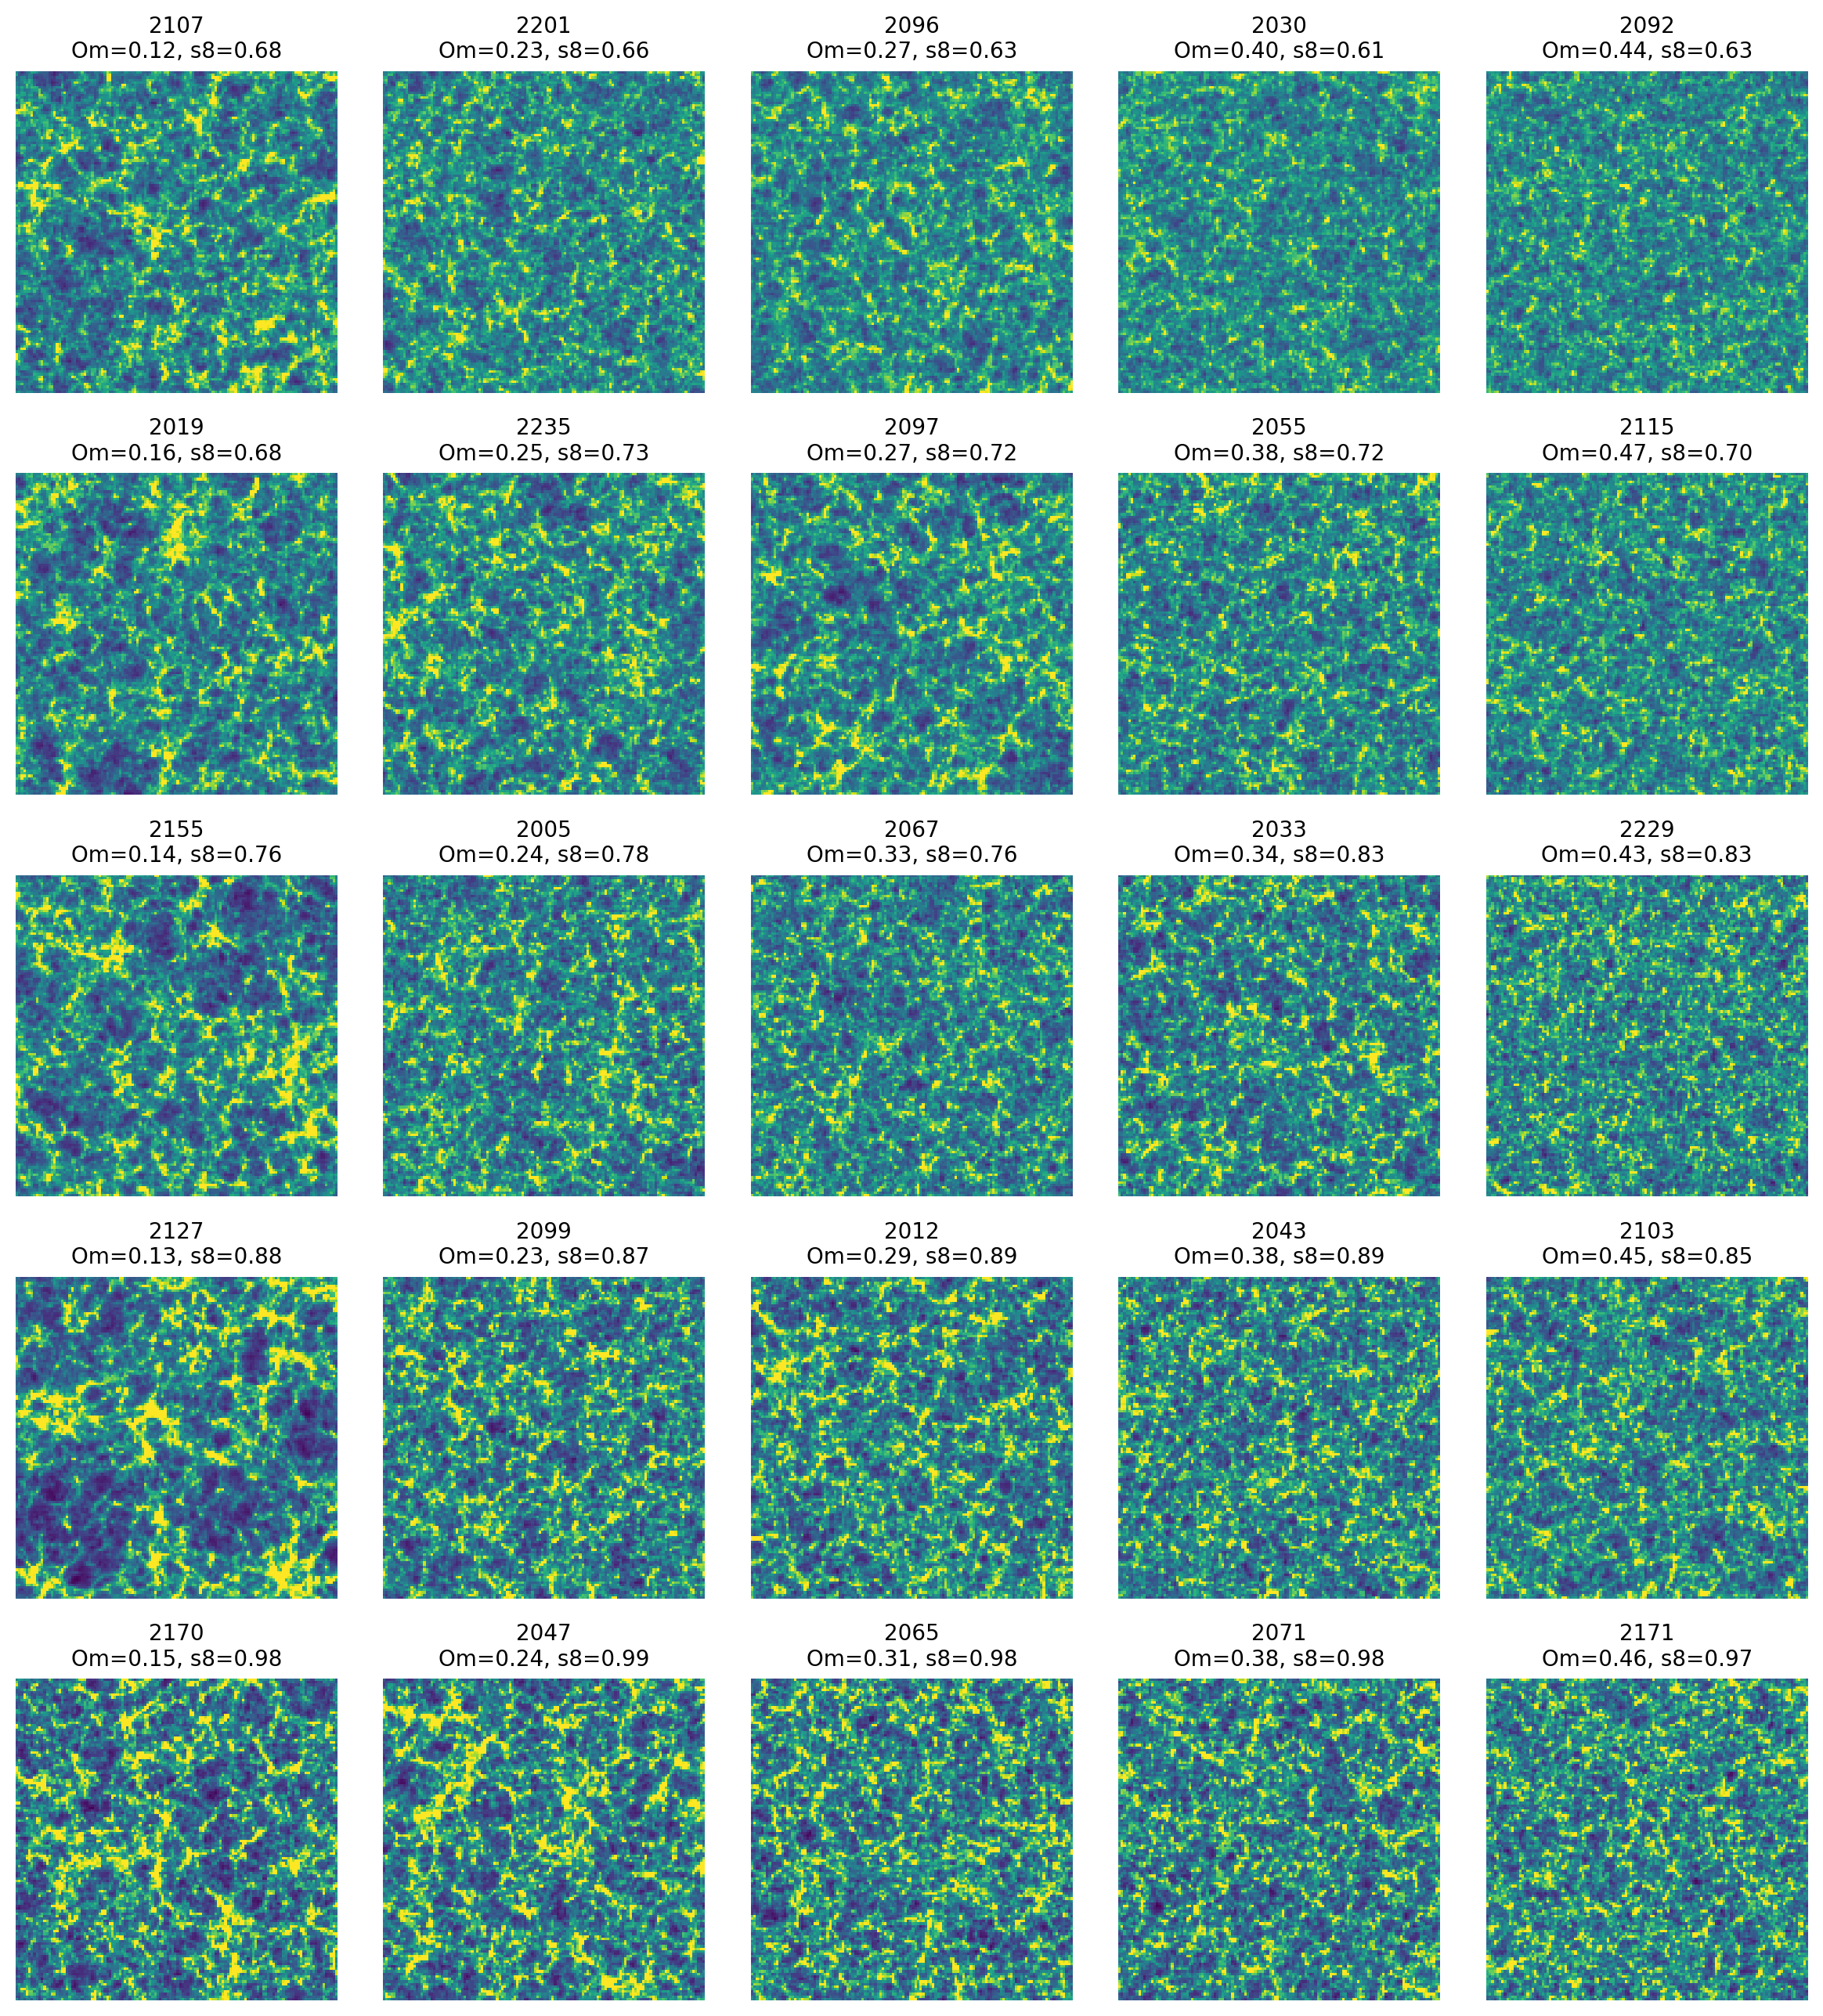

In [110]:
L, H = 5, 5
a = '0.666660'

xbins = np.linspace(ccosmo[:, 0].min(), ccosmo[:, 0].max(), L+1)
ybins = np.linspace(ccosmo[:, 4].min(), ccosmo[:, 4].max(), H+1)

f, axs = plt.subplots(H, L, figsize=(L*3, H*3.2), sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0.25, 'wspace': 0.05})
for i in tqdm(range(L)):
    for j in range(H):
        ax = axs[j, i]

        ind = np.random.choice(
            np.argwhere(
                (ccosmo[:, 0] >= xbins[i]) & (ccosmo[:, 0] < xbins[i+1]) &
                (ccosmo[:, 4] >= ybins[j]) & (ccosmo[:, 4] < ybins[j+1])
            ).flatten(), 1)[0]

        file = join(suitepath, str(clhid[ind]), 'nbody.h5')
        with h5py.File(file, 'r') as f:
            r = f[a]['rho'][:]
        ax.imshow(r[50:60, :128, :128].mean(axis=0), origin='lower',
                  vmin=-0.8, vmax=0.8, cmap='viridis')
        ax.set_title(
            f'{clhid[ind]}\nOm={ccosmo[ind, 0]:.2f}, s8={ccosmo[ind, 4]:.2f}',
            fontsize=10)
        ax.axis('off')